In [1]:
import scipy
import numpy as np
from tqdm.notebook import tqdm
from numba import njit

def np_array(shape):
    return np.array(shape, dtype=np.float32)

def np_zeros(shape):
    return np.zeros(shape, dtype=np.float32)
    
def np_ones(shape):
    return np.ones(shape, dtype=np.float32)

In [2]:
data = scipy.io.loadmat('mnist.mat')

In [3]:
testX, testY, trainX, trainY = data['testX'], data['testY'], data['trainX'], data['trainY']
# Normalize data
testX = (testX / 255.0).astype(np.float32)
trainX = (trainX / 255.0).astype(np.float32)
trainY = (trainY.T).astype(np.float32)
testY = (testY.T).astype(np.float32)

In [4]:
print(f"{testX.shape=}")
print(f"{testY.shape=}")
print(f"{trainX.shape=}")
print(f"{trainY.shape=}")

testX.shape=(10000, 784)
testY.shape=(10000, 1)
trainX.shape=(60000, 784)
trainY.shape=(60000, 1)


In [5]:
%matplotlib inline
from matplotlib import pyplot as plt
def display_image(normalized_data):
    # data should contain values in [0,1]
    scaled = normalized_data.reshape((28,-1)) * 255
    plt.imshow(scaled, interpolation='nearest')
    plt.show()

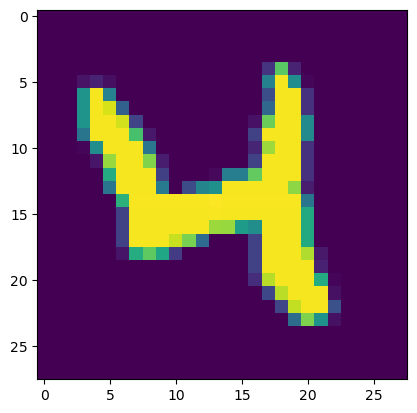

(None, array([4.], dtype=float32))

In [6]:
i = 20
display_image(trainX[i]), trainY[i]

# Part 1

## One-Versus-All Classifier 

We want to solve the problem

$$
\min_{x} || y - Ax ||
$$

where $A$ is our training data and $x$ is a set of weights for the data.

From the work shown in class, we show that the following must be true for a least squares solution $x$

$$
A^T y = A^T A x
$$

where $B$ is the matrix of basis vectors of the subspace given by $A$.

Then, we can solve for $x$, which must exist.

$$
x = (A^T A)^{-1} A^T y
$$

First, we want to compare class $i$ against all classes $\ne i$. To do this, we create a new $y$ marked either 1 or -1 depending on whether $y_i = i$ or $y_i \ne i$.

In [7]:
# Add column of ones for bias
def create_one_v_all_classifier(trainX, trainY, n):
    A = np.column_stack((trainX, np_ones(trainX.shape[0]))).astype(np.float32)
    y = np.copy(trainY)
    mask1, mask2 = trainY == n, trainY != n
    y[mask1] = 1.0
    y[mask2] = -1.0
    return A, y

Now we use the pseudoinverse function, which solves least-squares.

In [8]:
@njit
def solve_one_v_all_classifier(A, y):
    A = A.astype(np.float32)
    y = y.astype(np.float32)
    B = np.linalg.pinv(A) @ y
    return B.astype(np.float32)

And let's make some functions that compute and display the confusion matrices of the model. 

In [9]:
@njit
def binary_confusion_matrix(A, y, x):
    m = np.zeros((2,2))
    pred = np.sign(A @ x)
    tp = np.sum((pred == 1) & (y == 1))
    tn = np.sum((pred == -1) & (y == -1))
    fp = np.sum((pred == 1) & (y == -1))
    fn = np.sum((pred == -1) & (y == 1))
    return np.array([
        [tp, tn],
        [fp, fn]
    ])

@njit
def evaluate(X_test, y_test, x, n):
    m = binary_confusion_matrix(X_test, y_test, x)
    display_binary_confusion_matrix(m, n)
    
@njit
def display_binary_confusion_matrix(conf_matrix, n, ax):
    error_rate = conf_matrix[1, :].sum() / conf_matrix.sum()
    # fig, ax2 = plt.subplots(figsize=(8, 8))
    cax = ax.matshow(conf_matrix, cmap='Blues')
    # Add colorbar
    fig.colorbar(cax)
    # Set labels for the x and y axes
    ax.xlabel('Predicted')
    ax.ylabel('True')
    # Add a title with the error rate
    ax.title(f'Confusion Matrix for digit {n}\nError Rate: {error_rate:.2%}')
    # Display the values inside the matrix
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, f'{int(conf_matrix[i, j])}', ha='center', va='center', color='black')
            
    plt.show()

Now let's see what the results are for each class $0, \ldots, 9$

In [10]:
m_trains, m_tests = [], []
one_v_all_models = []
for n in tqdm(range(10)):
    A, y = create_one_v_all_classifier(trainX, trainY, n)
    x = solve_one_v_all_classifier(A, y)
    one_v_all_models.append(x) # save for later use
    m_train = binary_confusion_matrix(A, y, x)
    m_trains.append(m_train)
    A_test, y_test = create_one_v_all_classifier(testX, testY, n)
    m_test = binary_confusion_matrix(A_test, y_test, x)
    m_tests.append(m_test)
one_v_all_models = np.array(one_v_all_models).reshape((10, -1))

  0%|          | 0/10 [00:00<?, ?it/s]

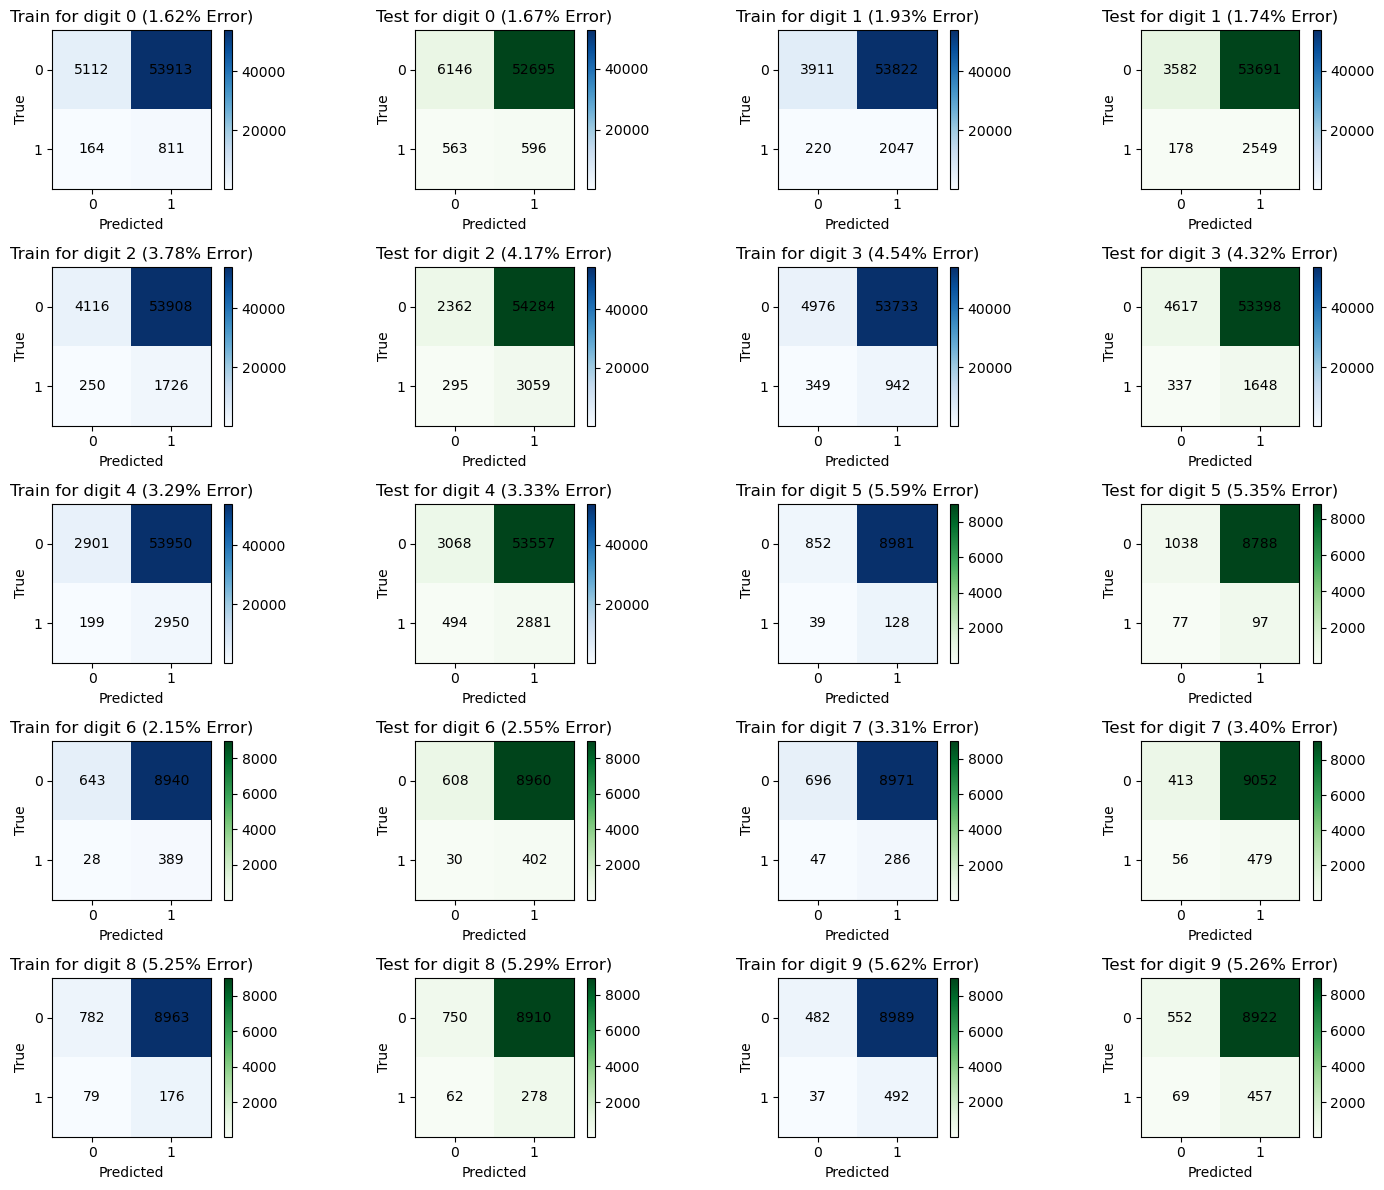

In [11]:
# source: ChatGPT
# Create a figure with 4 rows and 5 columns of subplots
def create_binary_confusion_matrix_plot(m_trains, m_tests, start=0):
    fig, axs = plt.subplots(5, 4, figsize=(15, 12))

    # Flatten the axs array to make it easier to iterate
    axs_flat = axs.flatten()

    # Iterate through the confusion matrices and plot them
    for i, (m_train, m_test) in enumerate(zip(m_trains, m_tests)):
        # Plot the confusion matrix for training data
        im = axs_flat[2*i].imshow(m_train, cmap='Blues', interpolation='nearest')

        # Add numbers to each square
        for x in range(2):
            for y in range(2):
                axs_flat[i].text(y, x, str(m_train[x, y]), color="black", ha="center", va="center")

        # Add labels, title, and colorbar
        axs_flat[2*i].set_title(f'Train for digit {i} ({100*m_train[1,:].sum()/m_train.sum():.2f}% Error)')
        axs_flat[2*i].set_xticks(np.arange(2))
        axs_flat[2*i].set_yticks(np.arange(2))
        axs_flat[2*i].set_xticklabels(['0', '1'])
        axs_flat[2*i].set_yticklabels(['0', '1'])
        axs_flat[2*i].set_xlabel('Predicted')
        axs_flat[2*i].set_ylabel('True')
        plt.colorbar(im, ax=axs_flat[i], fraction=0.046, pad=0.04)

        # Plot the confusion matrix for testing data
        im = axs_flat[2*i+1].imshow(m_test, cmap='Greens', interpolation='nearest')

        # Add numbers to each square
        for x in range(2):
            for y in range(2):
                axs_flat[i + 10].text(y, x, str(m_test[x, y]), color="black", ha="center", va="center")

        # Add labels, title, and colorbar
        axs_flat[2*i+1].set_title(f'Test for digit {i} ({100*m_test[1,:].sum()/m_test.sum():.2f}% Error)')
        axs_flat[2*i+1].set_xticks(np.arange(2))
        axs_flat[2*i+1].set_yticks(np.arange(2))
        axs_flat[2*i+1].set_xticklabels(['0', '1'])
        axs_flat[2*i+1].set_yticklabels(['0', '1'])
        axs_flat[2*i+1].set_xlabel('Predicted')
        axs_flat[2*i+1].set_ylabel('True')
        plt.colorbar(im, ax=axs_flat[i + 10], fraction=0.046, pad=0.04)

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()
    
create_binary_confusion_matrix_plot(m_trains, m_tests)

From the data, we see that digits 9, 8, 5, and 2 are the hardest to recognize.


Using the one-v-all classifier, we can build a multiclass classifier given by

$$
\hat f(\mathbf x) = \arg \max_{k=0, \ldots 9} g_k(\mathbf x)
$$

In [12]:
@njit
def multiclass_predict(models, x) -> int:
    preds = models @ x
    return int(np.argmax(preds))

In [13]:
conf_matrix_ova = np_zeros((10, 10))
testX_ones = np.c_[testX, np.ones(testX.shape[0])].astype(np.float32)
n = 0
for row, actual in zip(testX_ones, testY):
    pred = multiclass_predict(one_v_all_models, row)
    actual = int(actual)
    conf_matrix_ova[actual][pred] += 1

/var/folders/qs/qtpxyfmd5bv20vyzlfl11ncc0000gn/T/ipykernel_3616/274643382.py:3: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float32, 2, 'C', False, aligned=True), Array(float32, 1, 'A', False, aligned=True))
  preds = models @ x


In [14]:
def plot_multiclass_confusion_matrix(confusion_matrix, title=''):
    """
    Plot a multiclass confusion matrix with row and column totals.
    
    Parameters:
    - confusion_matrix: numpy array, the confusion matrix to be plotted
    
    Returns:
    None
    """
    # Calculate row and column totals
    row_totals = np.sum(confusion_matrix, axis=1)
    col_totals = np.sum(confusion_matrix, axis=0)

    # Calculate the error rate
    total_samples = np.sum(confusion_matrix)
    correct_predictions = np.trace(confusion_matrix)
    error_rate = 1 - (correct_predictions / total_samples)

    # Create a figure and axes
    fig, ax = plt.subplots()

    # Plot the confusion matrix using imshow
    cax = ax.imshow(confusion_matrix, cmap='Blues', interpolation='nearest')

    # Add text annotations for each element in the matrix
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            ax.text(j, i, int(confusion_matrix[i, j]), va='center', ha='center')

    # Set labels for rows and columns
    ax.set_xticks(np.arange(confusion_matrix.shape[1]))
    ax.set_yticks(np.arange(confusion_matrix.shape[0]))
    ax.set_xticklabels(np.arange(confusion_matrix.shape[1]))
    ax.set_yticklabels(np.arange(confusion_matrix.shape[0]))

    # Set labels and title
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(f'Confusion Matrix {title}\nError Rate: {error_rate:.2%}')

    # Add colorbar
    plt.colorbar(cax)

    # Display the plot
    plt.show()

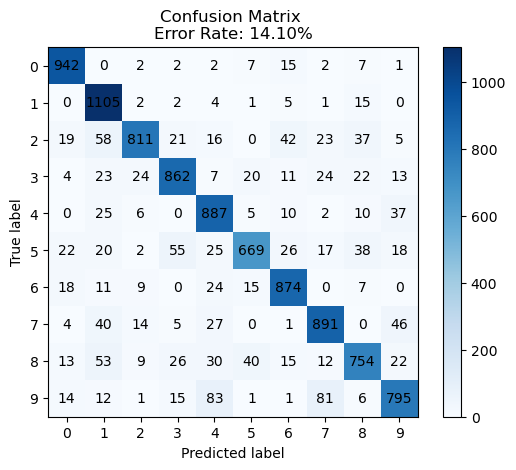

In [15]:
plot_multiclass_confusion_matrix(conf_matrix_ova)

## One-vs-One Classifiers

Now let's create a multiclass classifier built out of 1v1 classifiers. These will compare classes $i$ and $j$. 

$$
\hat f(\mathbf x) = \text{sign}(\mathbf{\beta x} + \alpha) = \begin{cases}
1 & \text{ if label = } i \\
-1 & \text{ if label = } j
\end{cases}
$$

To do this, we need to filter out only the data that belongs to classes $i$ and $j$ and train the model on this only.

In [16]:
def create_1v1_classifier(X, y, i, j):
    # Return matrix A such that only digits with labels with i or j are included
    # Return matrix y such that only labels with i or j are included
    mask = (y == i) | (y == j)
    big_mask = np.tile(mask, (1, X.shape[1]))
    A = X[big_mask].reshape((-1, X.shape[1]))
    A = np.column_stack((A, np.ones(A.shape[0]))) # add ones
    # Select only relevant labels
    _y = y[mask]
    # Re-label
    i_mask = _y == i
    j_mask = _y == j
    _y[i_mask] = 1
    _y[j_mask] = -1
    assert _y.shape[0] == A.shape[0] # should have same number of rows

    return A.astype(np.float32), _y.astype(np.float32)

The solution and prediction will be exactly the same.

In [17]:
@njit
def solve_1v1_classifier(A, y):
    B = np.dot(np.linalg.pinv(A), y)
    return B.astype(np.float32)

@njit
def predict_1v1(x, dig):
    return np.sign(dig @ x, dtype=np.int8)

Now that we can create a classifier for any pair $(i,j)$, we can combine all possible pairs in
the class set. Then, the multiclass model will evaluate all of these and count which has the highest
"vote" count.

In [18]:
import itertools
import functools
# All pairs of numbers under 10
pairs = list(itertools.combinations(range(10), 2))

def create_1v1_confusion_matrix(X, y, i, j, x):
    A, _y = create_1v1_classifier(X, y, i, j)
    return binary_confusion_matrix(A, _y, x)

In [19]:
def solve_multiclass_classifier(pairs, trainX, trainY):
    gs = [] # list of (i, j, solution)
    for i, j in tqdm(pairs):
        # Parse data for (i, j)
        A, y = create_1v1_classifier(trainX, trainY, i, j)
        # Solve
        x = solve_1v1_classifier(A, y)
        gs.append((i, j, x))
    return gs

def compute_1v1_confusion_matrices(gs, test_x, test_y):
    # compute confusion matrices for each pair
    return [(i, j, create_1v1_confusion_matrix(test_x, test_y, i, j, x)) for i, j, x in gs]

In [20]:
gs = solve_multiclass_classifier(pairs, trainX, trainY)

  0%|          | 0/45 [00:00<?, ?it/s]

In [21]:
m_train_1v1 = compute_1v1_confusion_matrices(gs, trainX, trainY)
m_test_1v1 = compute_1v1_confusion_matrices(gs, testX, testY)

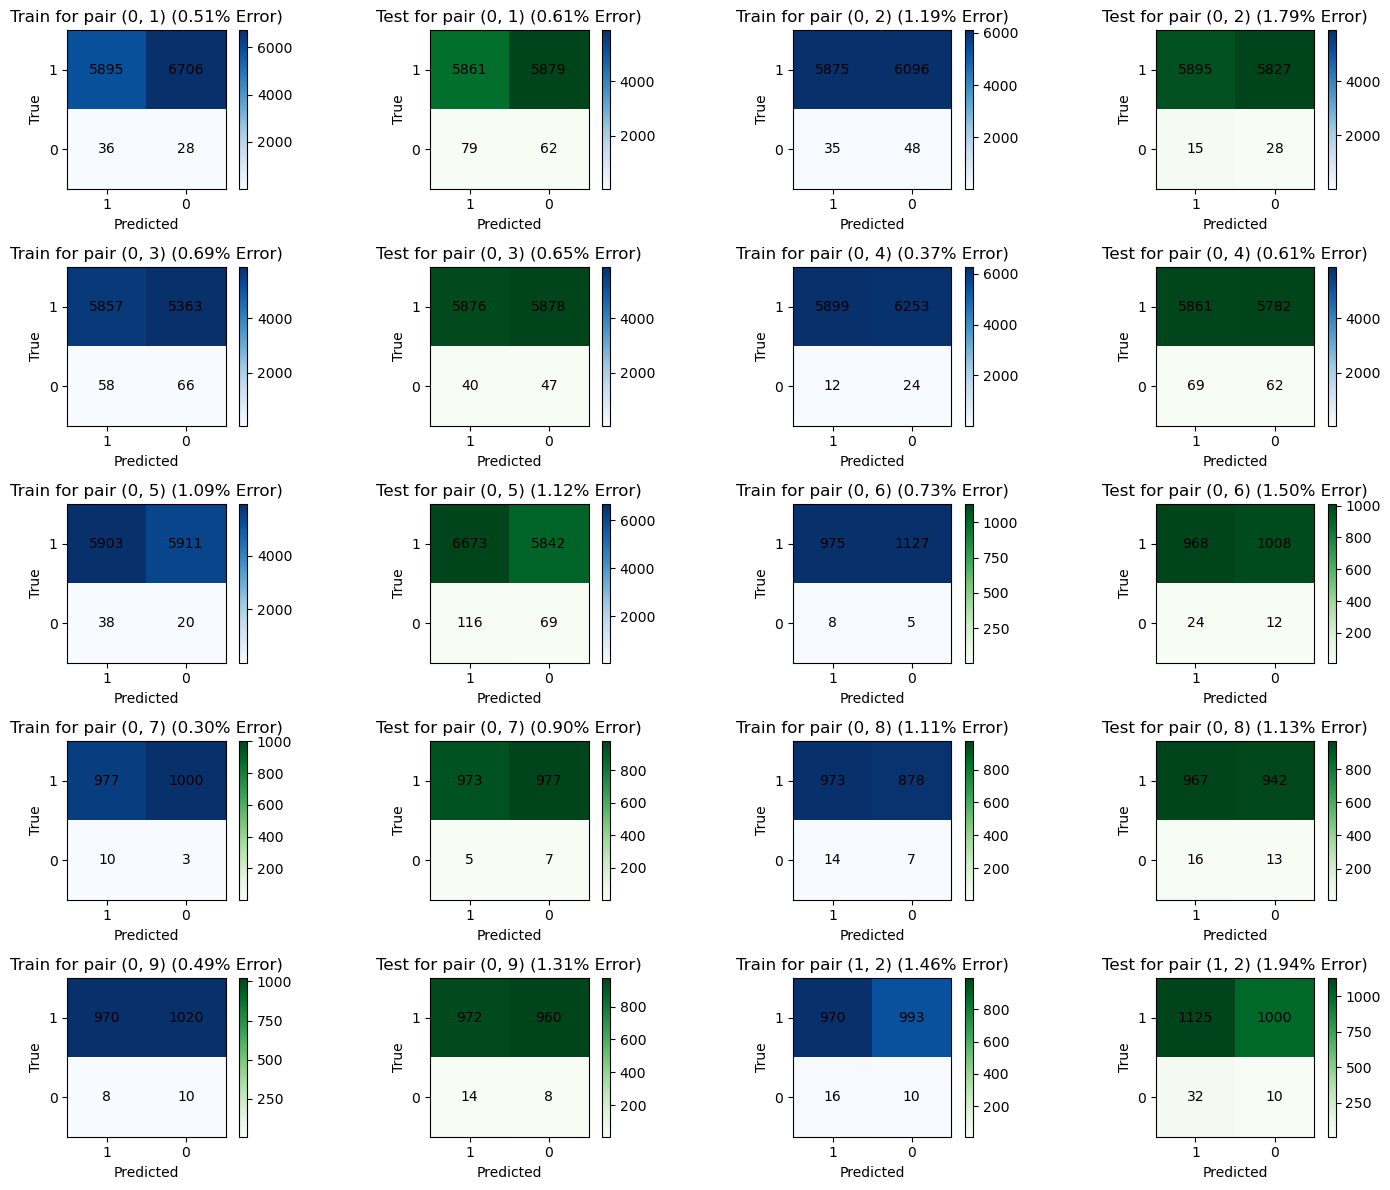

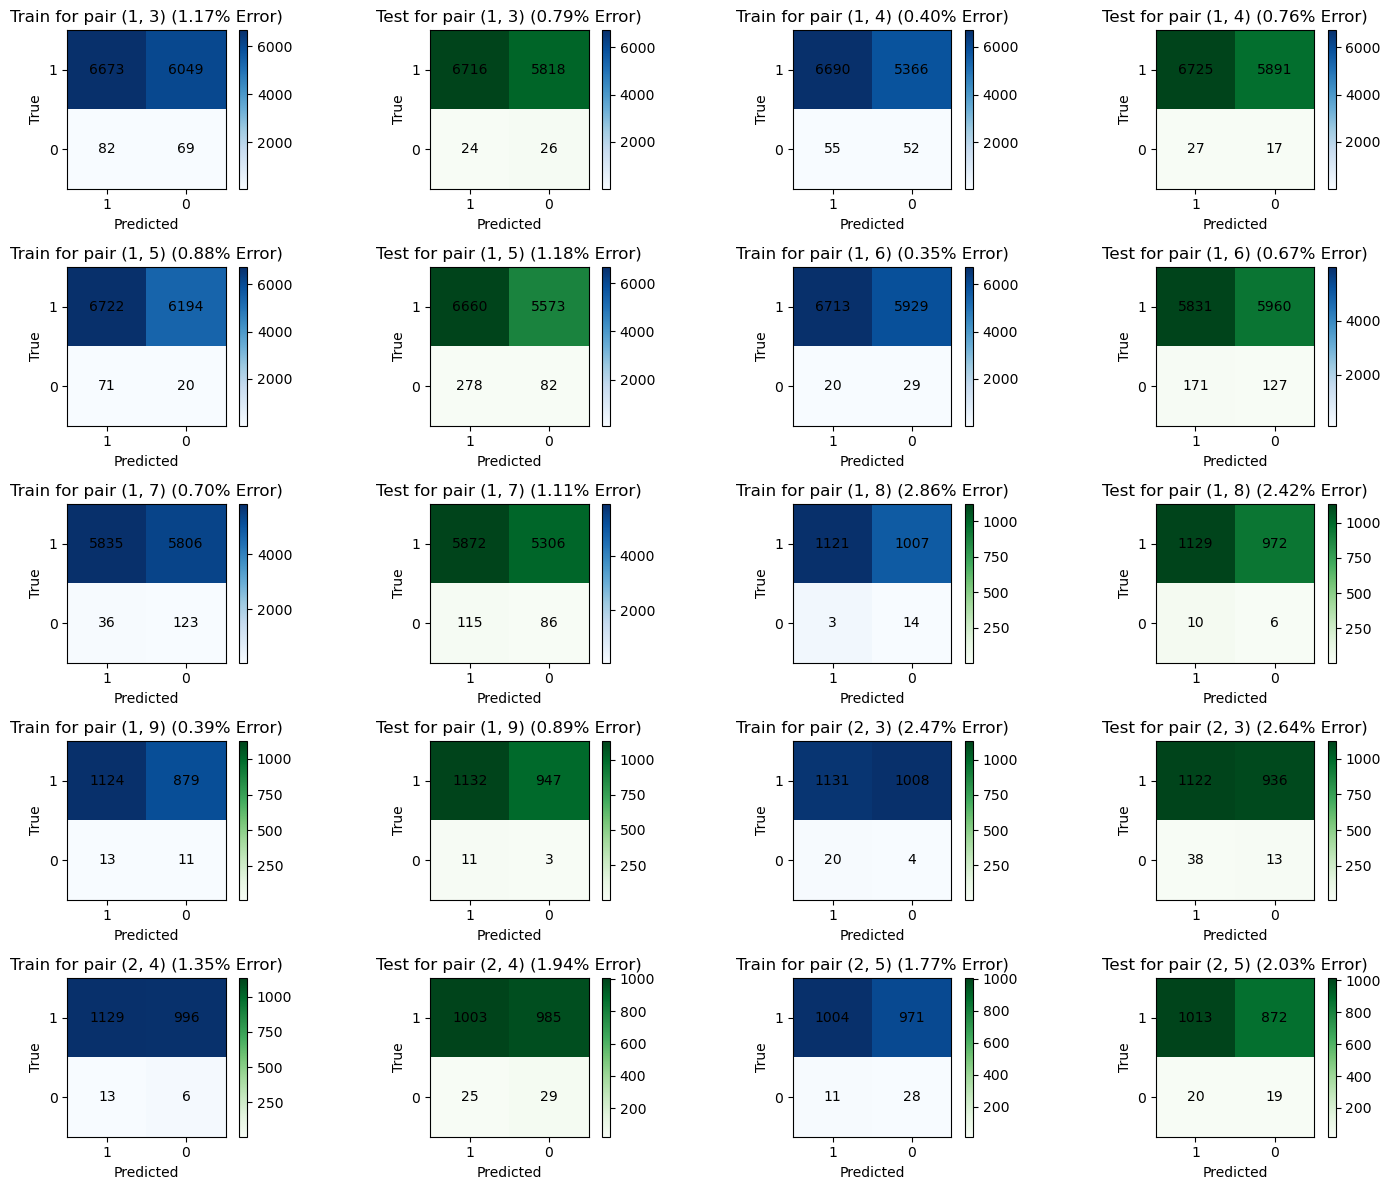

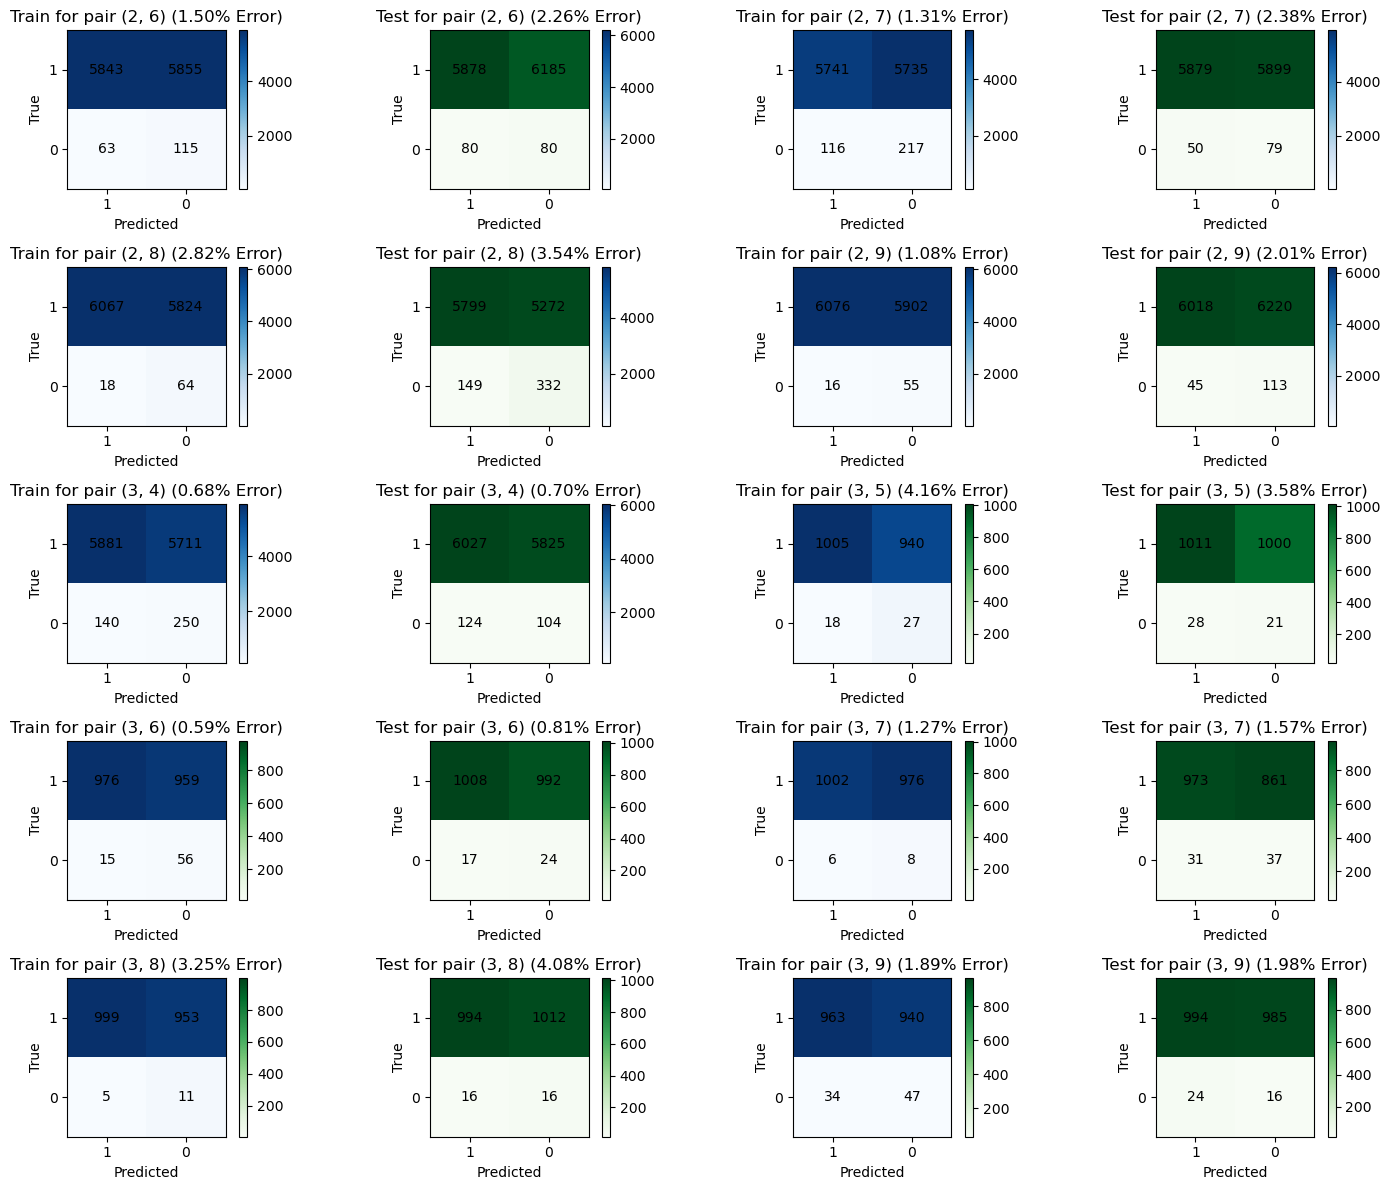

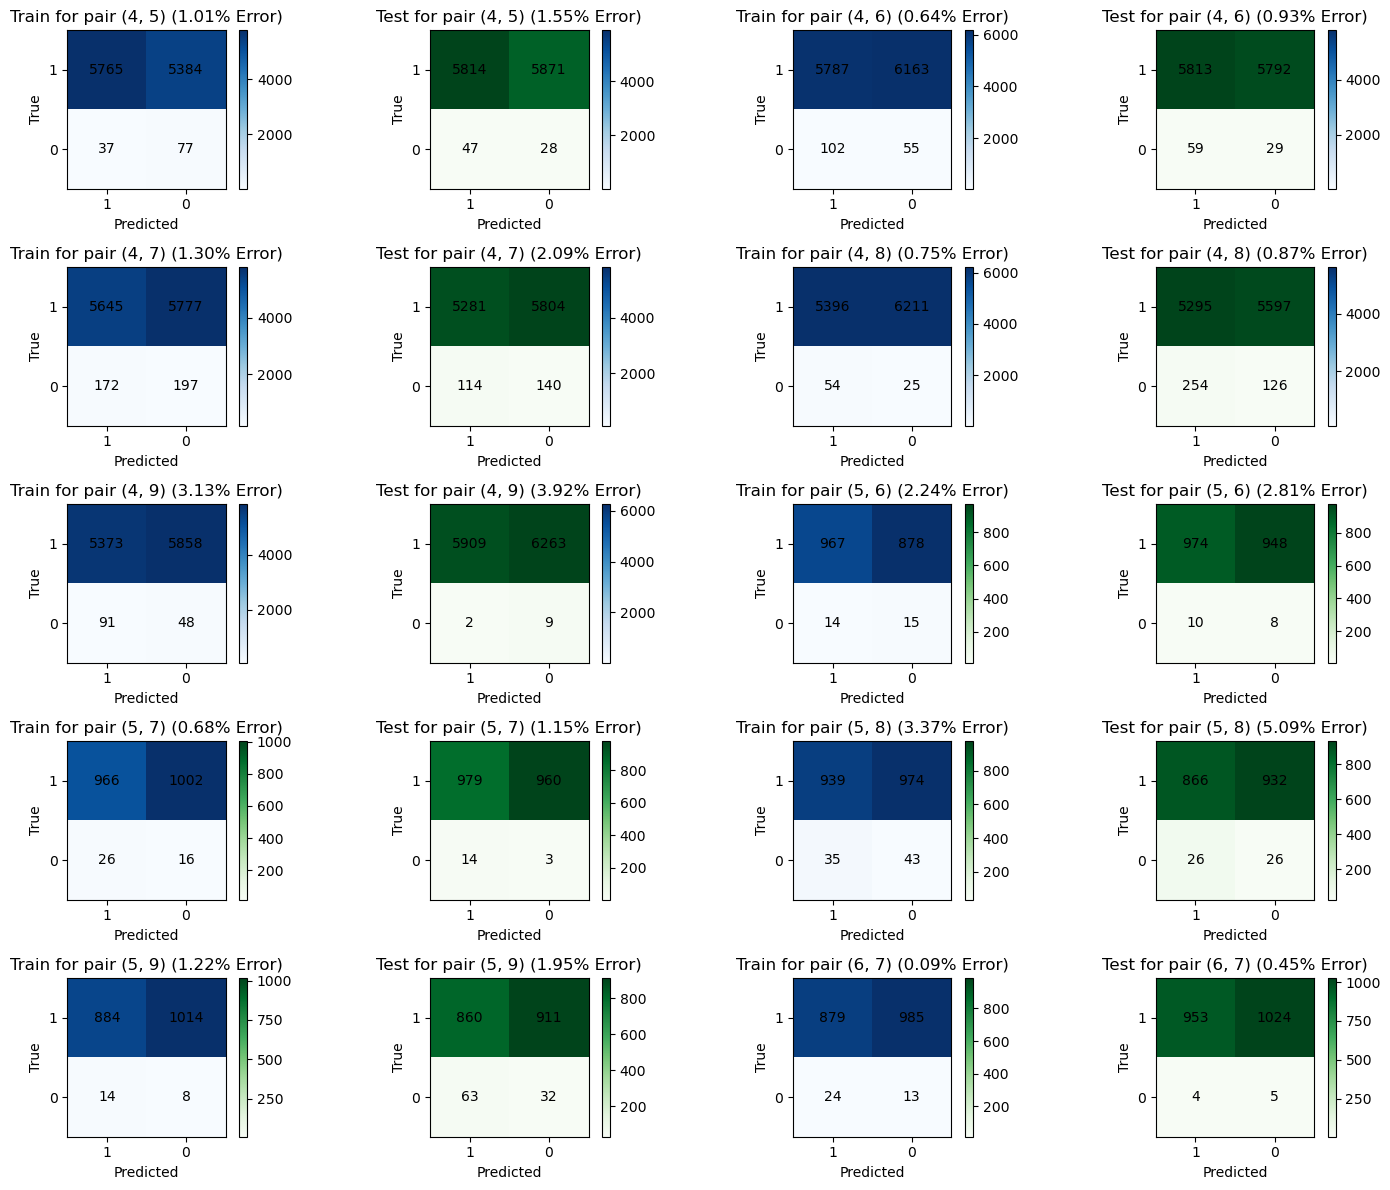

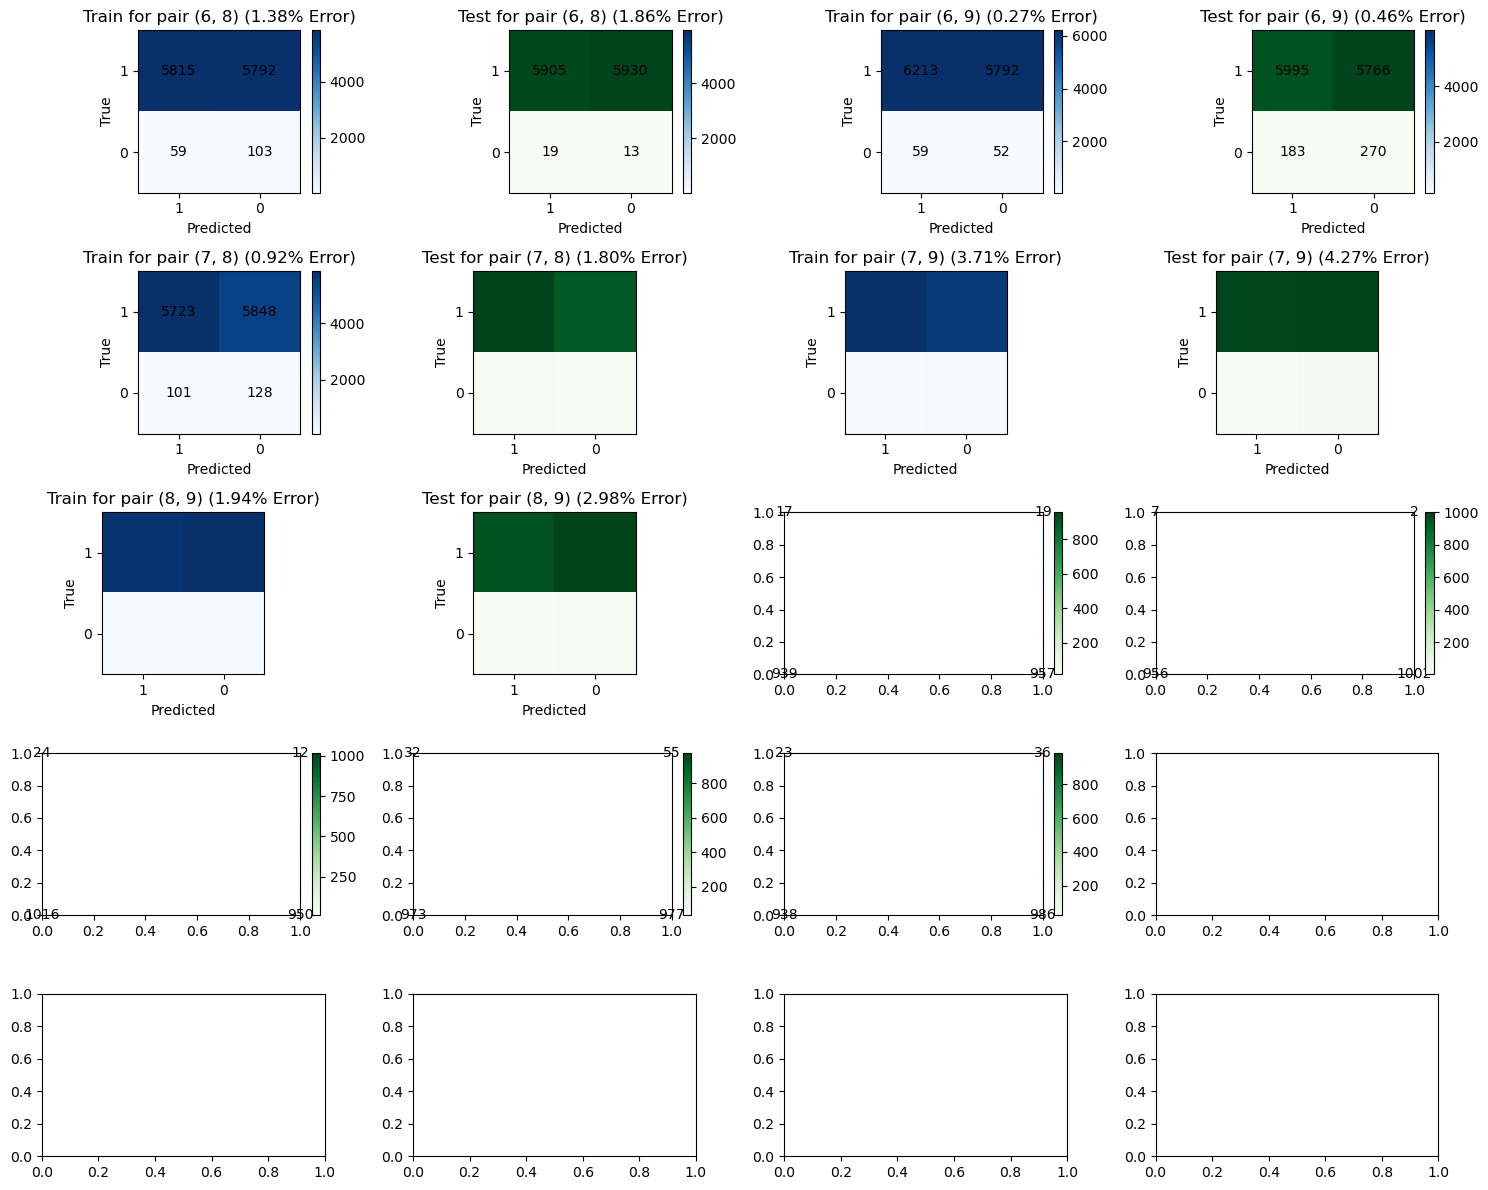

In [22]:
def grouper(iterable, n, *, incomplete='fill', fillvalue=None):
    "Collect data into non-overlapping fixed-length chunks or blocks"
    # grouper('ABCDEFG', 3, fillvalue='x') --> ABC DEF Gxx
    # grouper('ABCDEFG', 3, incomplete='strict') --> ABC DEF ValueError
    # grouper('ABCDEFG', 3, incomplete='ignore') --> ABC DEF
    args = [iter(iterable)] * n
    if incomplete == 'fill':
        return itertools.zip_longest(*args, fillvalue=fillvalue)
    if incomplete == 'strict':
        return zip(*args, strict=True)
    if incomplete == 'ignore':
        return zip(*args)
    else:
        raise ValueError('Expected fill, strict, or ignore')
        

def create_binary_confusion_matrix_plot(m_trains, m_tests):
    pairs = [(i, j) for i, j, x in m_trains]
    m_trains = [x for _, _, x in m_trains]
    m_tests = [x for _, _, x in m_tests]
    assert len(m_trains) == len(m_tests)
    fig, axs = plt.subplots(5, 4, figsize=(15, 12))

    # Flatten the axs array to make it easier to iterate
    axs_flat = axs.flatten()

    # Iterate through the confusion matrices and plot them
    for i, (m_train, m_test) in enumerate(zip(m_trains, m_tests)):
        j, k = pairs[i]
        # Plot the confusion matrix for training data
        im = axs_flat[2*i].imshow(m_train, cmap='Blues', interpolation='nearest')

        # Add numbers to each square
        for x in range(2):
            for y in range(2):
                axs_flat[i].text(y, x, str(m_train[x, y]), color="black", ha="center", va="center")

        # Add labels, title, and colorbar
        axs_flat[2*i].set_title(f'Train for pair ({j}, {k}) ({100*m_train[1,:].sum()/m_train.sum():.2f}% Error)')
        axs_flat[2*i].set_xticks(np.arange(2))
        axs_flat[2*i].set_yticks(np.arange(2))
        axs_flat[2*i].set_xticklabels(['1', '0'])
        axs_flat[2*i].set_yticklabels(['1', '0'])
        axs_flat[2*i].set_xlabel('Predicted')
        axs_flat[2*i].set_ylabel('True')
        plt.colorbar(im, ax=axs_flat[i], fraction=0.046, pad=0.04)

        # Plot the confusion matrix for testing data
        im = axs_flat[2*i+1].imshow(m_test, cmap='Greens', interpolation='nearest')

        # Add numbers to each square
        for x in range(2):
            for y in range(2):
                axs_flat[i + 10].text(y, x, str(m_test[x, y]), color="black", ha="center", va="center")

        # Add labels, title, and colorbar
        axs_flat[2*i+1].set_title(f'Test for pair ({j}, {k}) ({100*m_test[1,:].sum()/m_test.sum():.2f}% Error)')
        axs_flat[2*i+1].set_xticks(np.arange(2))
        axs_flat[2*i+1].set_yticks(np.arange(2))
        axs_flat[2*i+1].set_xticklabels(['1', '0'])
        axs_flat[2*i+1].set_yticklabels(['1', '0'])
        axs_flat[2*i+1].set_xlabel('Predicted')
        axs_flat[2*i+1].set_ylabel('True')
        plt.colorbar(im, ax=axs_flat[i + 10], fraction=0.046, pad=0.04)

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()
        
        
def filter_none(it):
    return [x for x in it if x is not None]

train_batches = grouper(m_train_1v1, 10)
test_batches = grouper(m_test_1v1, 10)

for b1, b2 in zip(train_batches, test_batches):
    create_binary_confusion_matrix_plot(filter_none(b1), filter_none(b2))

In [23]:
def predict_multiclass(gs, dig):
    scores = np.zeros(10)
    for i, j, x in gs:
        dig = dig.astype(np.float32)
        result = np.sign(dig @ x)
        if result == 1:
            scores[i] += 1
        else:
            scores[j] += 1
    return np.argmax(scores)

In [24]:
def create_multiclass_confusion_matrix(gs, X, y, progress=False):
    if not progress:
        tqdm = lambda x: x
    matrix = np.zeros((10, 10))
    for feature, actual in zip(tqdm(X), y):
        pred = predict_multiclass(gs, np.append(feature, 1))
        # Set the rows as the predicted value and the column as the actual value
        matrix[int(pred)][int(actual)] += 1
    return matrix

In [25]:
mult_m = create_multiclass_confusion_matrix(gs, testX, testY)

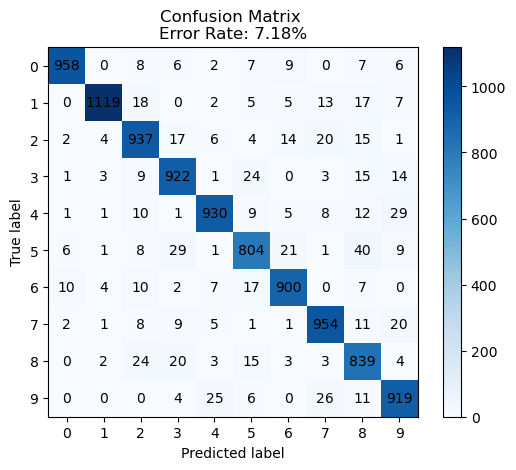

In [26]:
plot_multiclass_confusion_matrix(mult_m)

## Task 3

The 1v1 classifiers have a much lower error rate than the multiclass classfier, which has an error of 7.1%. They generalize well on the test data, offering a similar error rate as the training data. We can calculate the error for class $k$ by doing 

$$
\frac{\text{number of correctly predicted } k}{\text{total k}}
$$

In [27]:
error = np.zeros(10, dtype=np.float64)
for i in range(10):
    total = np.sum(mult_m[:, i])
    e = (total-mult_m[i][i])/ total
    error[i] = e

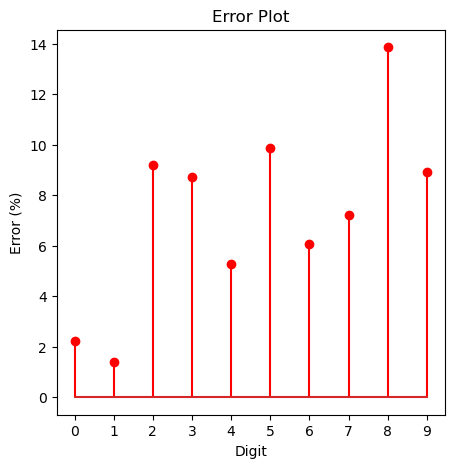

Error rates, highest to lowest
8: 13.860%
5: 9.865%
2: 9.205%
9: 8.920%
3: 8.713%
7: 7.198%
6: 6.054%
4: 5.295%
0: 2.245%
1: 1.410%


In [28]:
plt.figure(figsize=(5, 5))
plt.stem(range(len(error)), 100.0*error, linefmt='r-', markerfmt='ro')


# Adding labels and title
plt.xlabel('Digit')
plt.ylabel('Error (%)')
plt.title('Error Plot')
plt.xticks(list(range(len(error))))

# Display the plot
plt.show()
print("Error rates, highest to lowest")
for i, e in sorted(enumerate(error), key=lambda x: x[1], reverse=True):
    print(f"{i}: {100*e:.03f}%")

We see that the hardest ones to predict are 8, 5, 2, 9, and 3. The easiest ones are 0 and 1.

## Problem 2

First, let's create a random matrix with normally distributed values.

In [29]:
L = 1000
j = 28*28

In [30]:
identity = lambda x: x
sigmoid = lambda x: 1.0 / (1 + np.exp(-x))
sin = np.sin
relu = lambda x: np.maximum(x, 0)

In [31]:
funcs = {
    'relu': relu,
    'identity': identity,
    'sigmoid': sigmoid,
    'sin': sin,
}

@njit
def get_feature_params(L, j):
    W = np.random.normal(0, 1, (L, j))
    b = np.random.normal(0, 1, L)
    return W.astype(np.float32), b.astype(np.float32)

@njit
def map_to_feature_space(X, W, b):
    X = X.astype(np.float32)
    Y = X @ W.T + b
    return Y.astype(np.float32)

In [32]:
def gen_features(trainX, testX, L):
    W, b = get_feature_params(L, trainX.shape[1])
    train_feat = map_to_feature_space(trainX, W, b)
    test_feat = map_to_feature_space(testX, W, b)
    return train_feat, test_feat

train_feat, test_feat = gen_features(trainX, testX, L)

In [33]:
def solve_for_each_func(pairs, train_feat, trainY, funcs):
    d = {}
    for name, f in tqdm(funcs.items(), desc='Solving'):
        train_feat_g = f(train_feat)
        gs = solve_multiclass_classifier(pairs, train_feat_g, trainY)
        d[name] = gs
    return d

def evaluate_multiclass_feature_map(pairs, train_feat, trainY, test_feat, testY, solutions):
    for name, sol in solutions.items():
        train_feat_g = funcs[name](train_feat).astype(np.float32)
        test_feat_g = funcs[name](test_feat).astype(np.float32)
        mult_m = create_multiclass_confusion_matrix(sol, train_feat_g, trainY)
        plot_multiclass_confusion_matrix(mult_m, title=f" train ({name})")
        mult_m = create_multiclass_confusion_matrix(sol, test_feat_g, testY)
        plot_multiclass_confusion_matrix(mult_m, title=f" test ({name})")

In [34]:
sols = solve_for_each_func(pairs, train_feat, trainY, funcs)

Solving:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

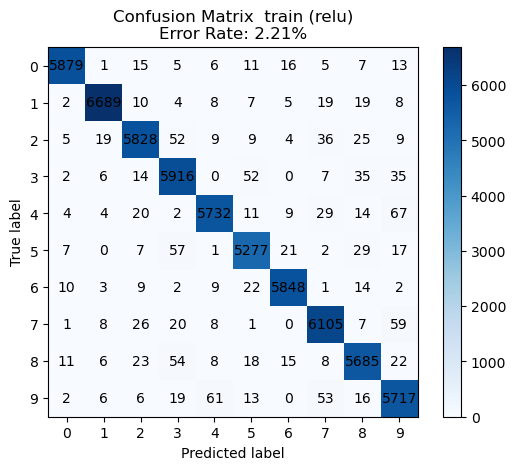

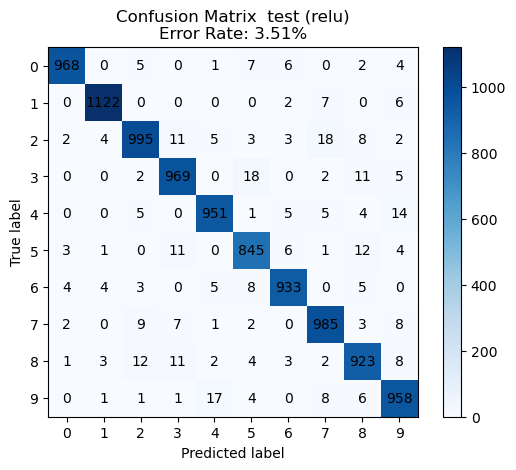

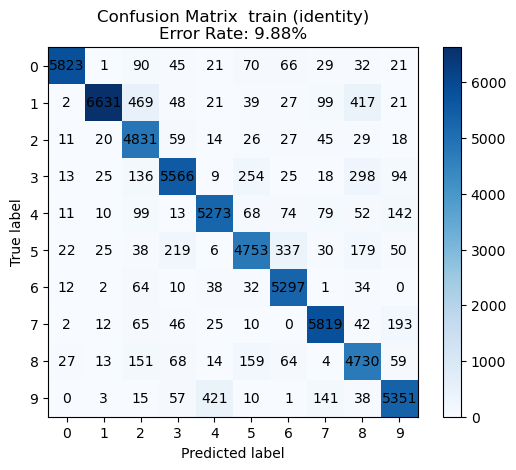

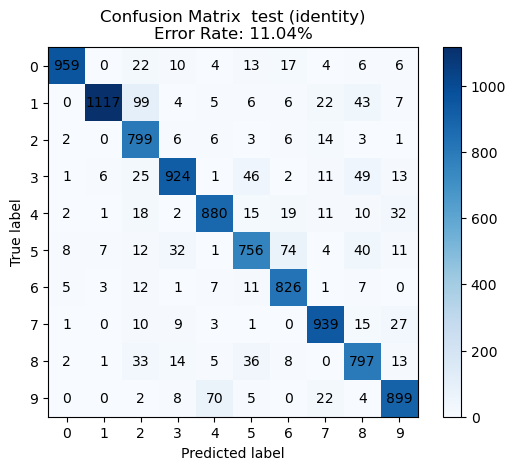

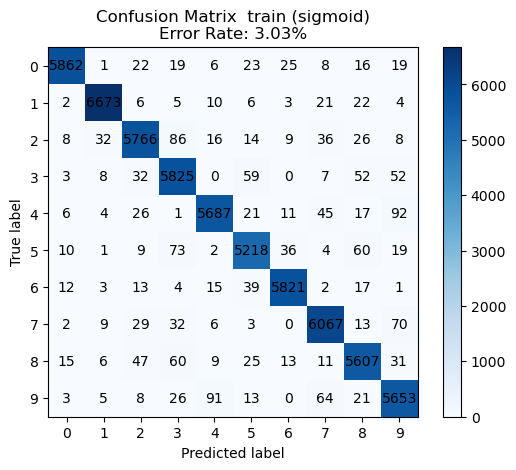

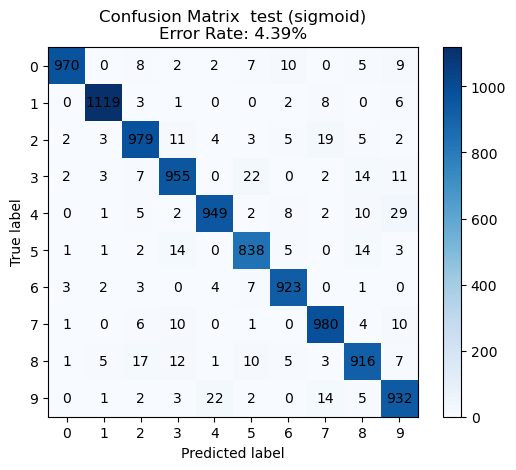

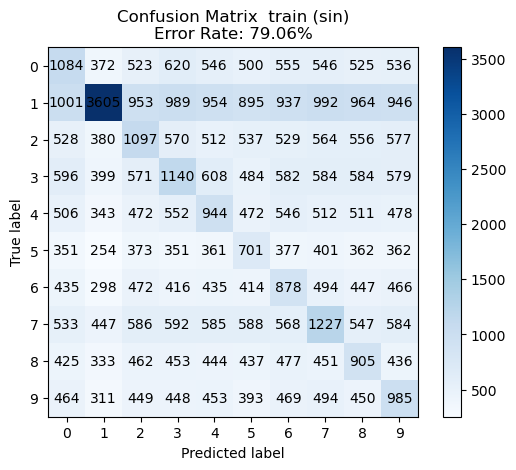

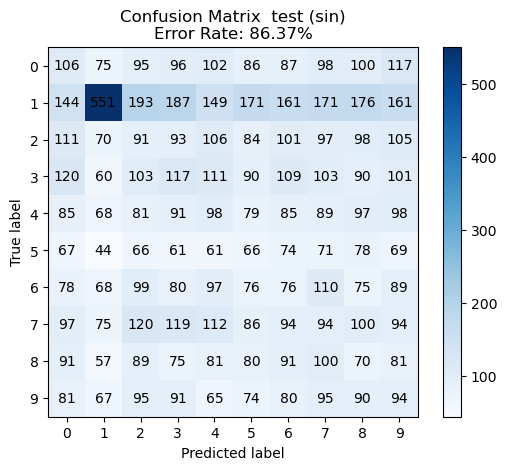

In [35]:
evaluate_multiclass_feature_map(pairs, train_feat, trainY, test_feat, testY, sols)

We see the best performance with the ReLU non-linearity.

Now let's see which values of $L$ result in the best error. Let's plot $L$ from $1000$, which is slightly below the input data size, all the way to $3000$ in $5$ increments.

In [36]:
def multiclass_error_rate(conf_matrix):
    return 100.0 * (1 - conf_matrix.trace()/conf_matrix.sum())

Ls = np.linspace(1000, 3000, 5)
g = relu
solutions_Ls = []
train_feat_gs = []
test_feat_gs = []
for L in tqdm(Ls):
    L = int(L)
    train_feat, test_feat = gen_features(trainX, testX, L)
    train_feat_g = g(train_feat)
    test_feat_g = g(test_feat)
    train_feat_gs.append(train_feat_g)
    test_feat_gs.append(test_feat_g)
    gs = solve_multiclass_classifier(pairs, train_feat_g, trainY)
    solutions_Ls.append(gs)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

In [37]:
test_error = []
train_error = []
mult_matrices = []
for gs, train_feat_g, test_feat_g in zip(tqdm(solutions_Ls), train_feat_gs, test_feat_gs):
    mult_m = create_multiclass_confusion_matrix(gs, train_feat_g, trainY)
    train_error.append(multiclass_error_rate(mult_m))
    mult_m = create_multiclass_confusion_matrix(gs, test_feat_g, testY)
    test_error.append(multiclass_error_rate(mult_m))
    mult_matrices.append(mult_m)

  0%|          | 0/5 [00:00<?, ?it/s]

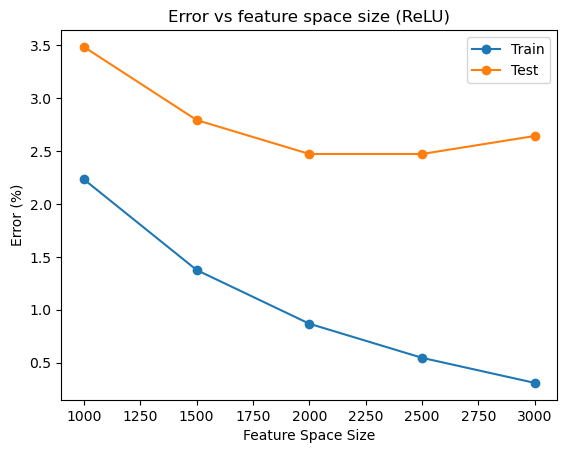

In [38]:
# Plotting the data with labels
plt.plot(Ls, train_error, label='Train', marker='o')
plt.plot(Ls, test_error, label='Test', marker='o')

# Adding title and labels
plt.title('Error vs feature space size (ReLU)')
plt.xlabel('Feature Space Size')
plt.ylabel('Error (%)')

# Adding a legend with labels for each line
plt.legend(['Train', 'Test'])

We see that the error rate on the training set reliably goes down as $L$ increases. However, we see that this is simply overfitting the training data since the test performance stagnates or even becomes worse.

The optimal $L$ seems to be $\approx 2500$. If we increase $L$ past that, training and inference time increases needlessly.